# Project 4: Image Stitching

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import random

## Overview

In this lab, you will obtain two or more separate images of a planar (or near-planar) scene and stitch them together by finding the perspective transformation(s) that map corresponding points to each other.

Here are example point correspondences from a pair of images of the 
whiteboard from the office hours room (before the semester started), and the resulting
mosaic after stitching the images together:

Left Image | Right Image
-----------------------|-----------------------
<p align="center"><img src="description-images/left_points.png" width="80%" /></p> | <p align="center"><img src="description-images/right_points.png" width="80%" /></p>

<strong>Merged Image</strong>
<p align="center">
  <img src="description-images/stitched_example.jpg" width="80%" />
</p>
  
(Note that this is actually a challenging pair of images because the
amount of overlapping content is very small -- it's much better to use
images that have more like 25-50% overlap!)

## Getting Started

In this Deepnote project, you will find a small assortment of
starter code as well as a couple of pairs of images of planar objects
suitable for stitching.

Before you begin coding, read over and run the **`transrot`** function, **`transrot_list`** function, and
**`t_homog`** function. These demonstrate some important aspects
of manipulating images and using transformations of the plane in OpenCV.

The function **`t_homog`** is just a demo; it does not have any use other than to demo the code inside it for you to use in your project. It has the `warp_bad` argument that that is set to true in the demo below to show what cropping is unacceptable.

It's a good idea to make sure you fully understand the code in
these example programs as you begin to work on your project.

Finally, you will use the **`pixel_highlighter.ipynb`** notebook to find the 
pixel coordinates of points in image files. If you have OpenCV installed on
your computer you can also use the **`pick_points.py`** file which can be used
on the command line like:

~~~ none
python pick_points.py data/weird1.jpg
~~~

It displays a help screen when it starts. You can re-display the help
screen by hitting the `?` key at any time.

Note that you only need to use pixel highlighter or the point-picking
program -- there is no need for you to fully understand the code it contains.

### Code Examples

In [ ]:
def transrot(image, trans_x, trans_y, angle_in_degrees):
    """Takes in image and 2D translation/rotation and spits out warped image, properly cropped
    Input:
        image - 2d np.array (np.uint8), image to warp
        trans_x - float or int, x component of translation
        trans_y - float or int, y component of translation
        angle_in_degrees - float or int, degree of 2D rotation in degrees
    Output:
        result - 2d np.array (np.uint8), warped image properly cropped
    """
    # Get the width and height
    w = image.shape[1]
    h = image.shape[0]

    # Construct a transformation matrix for the image that achieves
    # the desired rotation and translation
    M = np.eye(3,3, dtype='float32')

    # First, construct a matrix to rotate about the center
    M[0:2, :] = cv2.getRotationMatrix2D( (w*0.5, h*0.5), angle_in_degrees, 1 )

    # Then consider the translation.
    M[0,2] += trans_x
    M[1,2] += trans_y

    # Construct an array of points on the border of the image.
    # Note this is n-by-1-by-2 as cv2.perspectiveTransform
    # expects.  If you have a more typical n-by-2 array, you can
    # use numpy's reshape method to get it into the correct shape.
    p = np.array( [ [[ 0, 0 ]],
                     [[ w, 0 ]],
                     [[ w, h ]],
                     [[ 0, h ]] ], dtype='float32' )

    # Send the points through the transformation matrix.
    allpoints = cv2.perspectiveTransform(p, M)

    # Compute the bounding rectangle for all points (note this gives
    # integer coordinates).
    box = cv2.boundingRect(allpoints)

    # Get the upper left corner of the rectangle, and its dimensions as well.
    p0 = box[0:2]
    dims = box[2:4]

    # Get the transformation matrix and update it to put the top
    # left corner at the origin. by pre-multiplying a translation
    # matrix
    T = np.array([[1, 0, -p0[0]],
                  [0, 1, -p0[1]],
                  [0, 0, 1]])

    # use @ for matrix multiplication with numpy arrays (remember
    # * gives element-wise product)
    M = T @ M

    # Update each border polygon to put the top left corner at the
    # origin.
    for j in range(len(allpoints)):
        allpoints[j] -= p0

    # Warp the image to the destination in the temp image.
    result = cv2.warpPerspective(image, M, tuple(dims))
    return result




In [ ]:
# See block below for example
def transrot_list(data_list):
    """Takes in list of images and 2D translations/rotations and gives resulting image, properly cropped
    Input:
        data_list - list of tuples/lists with the following elements:
            * image - 2d np.array (np.uint8), image to warp
            * trans_x - float or int, x component of translation
            * trans_y - float or int, y component of translation
            * angle_in_degrees - float or int, degree of 2D rotation in degrees
    Output:
        result - 2d np.array (np.uint8), warped images put together properly cropped
    """


    # Get the number of pictures
    numpics = len(data_list)

    # Initialize an empty array to hold all of the points we will use.
    allpoints = np.empty( (0, 1, 2), dtype='float32' )

    # List of all images used.
    images = []

    # List of all transformation matrices used.
    matrices = []

    # List of all outlines of the resulting images after transformation.
    polygons = []

    # Iterate over each argument
    for p, data in enumerate(data_list):

        # Get filename, x, y, and angle:
        image = data[0]
        x = data[1]
        y = data[2]
        a = data[3]

        # Get the width and height
        w = image.shape[1]
        h = image.shape[0]

        # Construct a transformation matrix for the image that achieves
        # the desired rotation and translation
        M = np.eye(3,3, dtype='float32')

        # First, construct a matrix to rotate about the center
        M[0:2, :] = cv2.getRotationMatrix2D( (w*0.5, h*0.5), a, 1 )

        # Then consider the translation.
        M[0,2] += x
        M[1,2] += y

        # Construct an array of points on the border of the image.
        # Note this is n-by-1-by-2 as cv2.perspectiveTransform
        # expects.  If you have a more typical n-by-2 array, you can
        # use numpy's reshape method to get it into the correct shape.
        p = np.array( [ [[ 0, 0 ]],
                        [[ w, 0 ]],
                        [[ w, h ]],
                        [[ 0, h ]] ], dtype='float32' )

        # Send the points through the transformation matrix.
        pp = cv2.perspectiveTransform(p, M)

        # Add to the lists above
        images.append(image)
        matrices.append(M)
        polygons.append(pp)

        # Append points to the array of all points.
        allpoints = np.vstack((allpoints, pp))

    # Compute the bounding rectangle for all points (note this gives
    # integer coordinates).
    box = cv2.boundingRect(allpoints)

    # Get the upper left corner of the rectangle, and its dimensions as well.
    p0 = box[0:2]
    dims = box[2:4]

    # Construct an RGB image with the appropriate size to hold all of the
    # results.
    result = np.zeros( (dims[1], dims[0], 3), dtype='uint8' )

    # We need a temporary array to help us compose the images below.
    temp = np.empty_like(result)

    # We also need a mask to select the correct pixels.
    mask = np.empty( (dims[1], dims[0]), dtype='uint8' )

    # This creates a boolean view of the mask, which we can use to do a
    # masked copy below.  No data is copied.
    bmask = mask.view(bool)

    # For each image
    for i in range(len(images)):
        # Get the transformation matrix and update it to put the top
        # left corner at the origin. by pre-multiplying a translation
        # matrix
        M = matrices[i]

        T = np.array([[1, 0, -p0[0]],
                      [0, 1, -p0[1]],
                      [0, 0, 1]])

        # use @ for matrix multiplication with numpy arrays (remember
        # * gives element-wise product)
        M = T @ M

        # Update each border polygon to put the top left corner at the
        # origin.
        for j in range(len(polygons[i])):
            polygons[i][j] -= p0

        # Zero out the mask and color in white where the image will go.
        mask[:] = 0
        cv2.fillConvexPoly(mask, polygons[i].astype('int32'), (255,255,255))

        # Warp the image to the destination in the temp image.
        cv2.warpPerspective(images[i], M, tuple(dims), temp)

        # Use the mask to copy the pixels into the final image.
        result[bmask] = temp[bmask]

    return result


In [ ]:

def t_homog(image, warp_bad=False):

    # Load an image
    orig = image.copy()

    # Get its size 
    h, w = orig.shape[:2]
    size = (w, h)

    ######################################################################
    # Now make a neat "keystone" type homography by composing a
    # translation, a simple homography, and the inverse translation.

    # Translate center of image to (0,0)
    Tfwd = np.eye(3)
    Tfwd[0,2] = -0.5 * w
    Tfwd[1,2] = -0.5 * h

    # Get inverse of that
    Tinv = np.linalg.inv(Tfwd)

    # Homography that decreases homogeneous "w" coordinate with increasing
    # depth so bottom rows appear "closer" than top rows".
    H = np.eye(3)
    H[2,1] = -0.002

    S = np.eye(3)
    S[0,0] = 0.5
    S[1,1] = 0.5

    # Compose the three transforms together using matrix
    # multiplication. 
    #
    # Use @ operator to do matrix multiplication on numpy arrays
    # (remember * gives element-wise product)

    H = S @ Tinv @ H @ Tfwd

    # Show the warped version. Note that you don't need to pass a
    # "destination" image into warpPerspective - you can just get the
    # return value.
    warped = cv2.warpPerspective(orig, H, size)

    if warp_bad:
        return warped

    ######################################################################
    # Now translate the final warped image so we can see it all. This uses
    # the same trick from transrot.py, except instead of modifying the
    # homography matrix directly, just composes it with a translation.

    # Get corner points of original image - note this is shaped as an
    # n-by-1-by-2 array, because that's what cv2.perspectiveTransform
    # expects. If you have a more typical n-by-2 array, you can use
    # numpy's reshape method to get it into the correct shape.
    p = np.array( [ [[0, 0]],
                    [[w, 0]],
                    [[w, h]],
                    [[0, h]] ], dtype='float32' )

    # Map through warp
    pp = cv2.perspectiveTransform(p, H)

    # Get integer bounding box of form (x0, y0, width, height)
    box = cv2.boundingRect(pp)

    # Separate into dimensions and origin
    dims = box[2:4]
    p0 = box[0:2]

    # Create translation transformation to shift image
    Tnice = np.eye(3)
    Tnice[0,2] -= p0[0]
    Tnice[1,2] -= p0[1]

    # Compose them via matrix multiplication
    Hnice = Tnice @ H

    # Show it
    warpedNice = cv2.warpPerspective(orig, Hnice, dims)
    return warpedNice

Text(0.5, 1.0, 'Bad Warped Image')

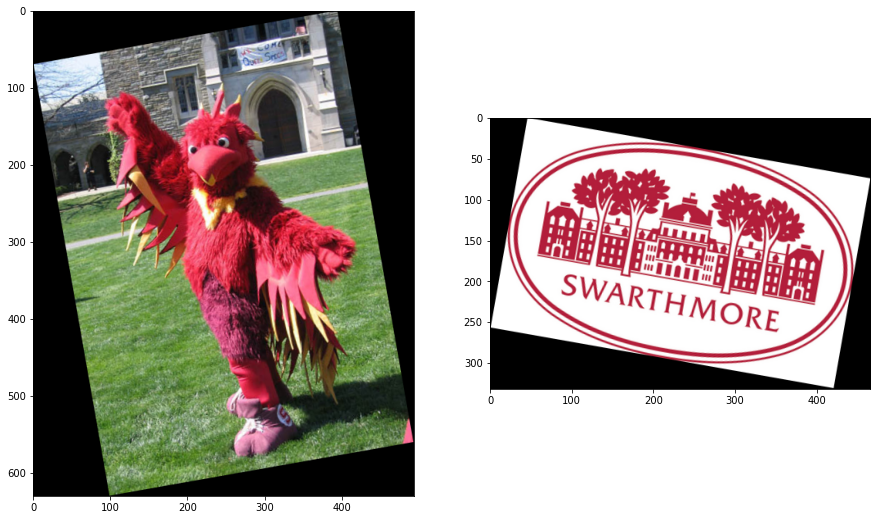

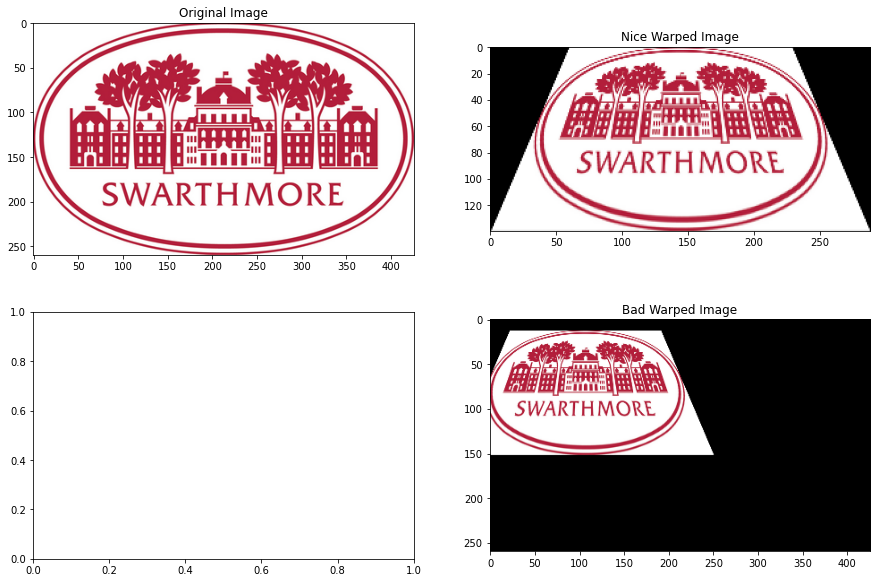

In [ ]:
img1 = cv2.cvtColor(cv2.imread('/work/data/phoenix.jpg'), cv2.COLOR_BGR2RGB)
result1 = transrot(img1, 30, 20, 10)
img2 = cv2.cvtColor(cv2.imread('/work/data/swat_logo.png'), cv2.COLOR_BGR2RGB)
result2 = transrot(img2, 140, 360, -10)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(result1)
ax[1].imshow(result2)

homog_warp_nice = t_homog(img2)
homog_warp_bad = t_homog(img2, warp_bad=True)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0, 0].imshow(img2)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(homog_warp_nice)
ax[0, 1].set_title("Nice Warped Image")
ax[1, 1].imshow(homog_warp_bad)
ax[1, 1].set_title("Bad Warped Image")



## Image Stitching

Your job is to update the **`stitcher`** function below
to emit an image that combines the two
input images you specify in the arguments.

Here are the steps you will want to follow:

 1. Identify a set of four or more (hint: more is better)
    corresponding points in two images and save either in a text
    files with one `x, y` point per line, or just in a list in a code
    block in this notebook. You can use the
    **`pixel_highlighter.ipynb`** or **`pick_points.py`** program
    from the starter code to do this.
    
    Point data for the **`weird1.jpg`** and **`weird2.jpg`** images
    is included with your starter code (in their corresonding `.txt`
    files), so you might want to start with that dataset!
    
    Each identically numbered point in each image should correspond to
    the same physical point in the world. For example for the
    **`weird1.jpg`** and **`weird2.jpg`** images and tagged points
    included with the starter code, point #1 in both images
    corresponds to the top-left of the book.
    
    The text filename is obtained by replacing the image file
    extension (e.g. `'.png'` or `'.jpg'`) with `'.txt'`.  So the text
    file corresponding to **`data/weird1.jpg`** is
    **`data/weird1.txt`**.
    
 2. Find the homography $\mathrm{H}$ that best transforms the set of
    points from image $A$ into the set from image $B$.  To do this,
    use the `cv2.findHomography` function (documentation
    [here](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780),
    example code
    [here](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html)).
  
    Note that `cv2.findHomography` expects you to provide points in
    arrays of shape `(n, 1, 2)` with data type `numpy.float32`.  I
    suggest you omit the optional arguments, and only pass in the
    first two arguments.
    
    Finally, note that the function returns a pair containing the
    desired homography as well as a mask. You can safely ignore the
    mask, provided you are picking the point correspondences by hand
    (it can be useful for machine-created point correspondences).
    
 3. Now you will need to potentially enlarge and translate the
    viewport to fit the images together in one composition. Let’s
    assume you are warping image $A$ into the frame of image $B$, as
    shown below:
    
    <p align="center">
        <img src="description-images/homography-scaling.png" width="80%" />
    </p>
    
    You will need to create an array of eight points: the four
    unmodified corner points of image $B$, and the four corner points
    of image $A$, mapped through your homography $\mathbf{H}$ by the
    cv2.perspectiveTransform function. Use the [`cv2.boundingRect`](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7)
    function to obtain the top-left point $(x_0, y_0)$ and the viewport size
    $(w_C, h_C)$.
    
 4. Define the homography $\mathbf{M} = \mathbf{T} \mathbf{H}$, where $\mathbf{T}$ is the translation

    $$
    \mathbf{T} = \left[\begin{array}{ccc} 1 & 0 & -x_0 \\
        0 & 1 & -y_0 \\
            0 & 0 & 1 \end{array}\right]
    $$
    
    Make sure to use matrix product and not element-wise product to
    compose these two transformations! Use
    [`numpy.matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html)
    or the `@` operator to do matrix multiplication instead of
    the element-wise multiplication provided by the `*` operator.

 5. Use the
    [`cv2.warpPerspective`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)
    function to prepare two images of size $(w_C, h_C)$ to be
    superimposed together. You will warp image $A$ with matrix
    $\mathbf{M}$ and warp image $B$ with matrix $\mathbf{T}$ to obtain
    two separate warped images.
    
 6. Combine the warped images together using simple averaging so the
    quality of the image stitching is readily apparent. Assuming
    `warpA` and `warpB` hold the respective outputs of
    `cv2.warpPerspective`, you can obtain an output image with the
    code

    ~~~ Python 
    finalImage = warpA//2 + warpB//2
    ~~~
    
    This will result in reduced brightness where the images don't
    overlap.  If you want, you can optionally use masks to find the
    overlapping areas and display the average there, and simply copy from
    one image or the other in non-overlapping areas (this is similar
    to what my code does to generate the example images in this
    document).
    
    But please make sure there you do a 50-50 average where the images
    do overlap, so I can see the quality of your image alignment!
    
    
 7. Use
    [`cv2.imwrite`](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#gabbc7ef1aa2edfaa87772f1202d67e0ce)
    to save your merged image to a file named **`output.jpg`**.
    
If you run into any problems coding this up, make sure you have a
clear understanding of what the example code is doing! There are
lots of easy pitfalls to avoid if you read the code and comments.

## Troubleshooting/tips

* Since four points exactly determine a homography, try starting with
   a minimal set of four points and only adding/refining points after
   you have a rough alignment. You should be able to get a coarse
   alignment by running on the existing **`weird1.jpg`** and
   **`weird2.jpg`** data.
   
 * Only pick points that are easy to locate in multiple
   images. Corners and intersections of lines are good.
   Points inside uniformly-colored areas are bad.

 * If your images are aligning OK in some places but not others, try
   adding more points and/or refining your existing points. Here is my
   output for the data that comes with the starter code:
   
    <p align="center">
       <img src="description-images/weird_mediocre.jpg" width="65%" />
    </p>

   The ghosting or "echoes" around the alien face and the ladder
   indicate the alignment is not very good and could benefit from
   adding & improving point correspondences.

 * If your images are not aligning horribly or you are getting bizarre
   warps in your output, make sure your points are numbered
   consistently across both input images. Here's the glitchy output
   that results if I shuffle the order of the points for
   **`weird1.jpg`**:

    <p align="center">
       <img src="description-images/weird_shuffle.jpg" width="65%" />
    </p>
      
   Remember, a homography can turn the unit square into an arbitrary
   quadrilateral, including the "unit bowtie", which accounts
   for the odd warp above.
   
    <p align="center">
       <img src="description-images/bowtie-transform.png" width="50%" />
    </p>


   

## RANSAC on a Specific Example

Below are two images, one of a box and one of that box alongside many others. Their are some bad matches in the `box.txt` and `box_in_scene.txt` files, as shown in the image below:
**`box.png`** | **`box_in_scene.png`**
-----------------------|-----------------------
<p align="center"><img src="data/box.png" width="90%" /></p> | <p align="center"><img src="data/box_in_scene.png" width="60%" /></p>

<strong>Matches</strong>
<p align="center">
    <img src="description-images/box_all_matches.png" width="65%" />
</p>

Rather than trying to manually go through all the matches, use RANSAC to find the maches in the scene. Once you've done that, find the homography that maps `box.png` to `box_in_scene.png`. This will require the use of `cv2.perspectiveTransform` method ([link to documentation](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gad327659ac03e5fd6894b90025e6900a7)). Note I expect you to implement RANSAC yourself. If you want to compare your result to the true result, you can use the `cv2.findHomography` option `method=cv2.RANSAC` but you shouldn't use that by default in your **`stitcher`** function.

Recall the algorithm for RANSAC for homography estimation is, given initial points `pts1`, `pts2`

* Until you reach the maximum number of iterations `Nmax`:

    * Select 4 random rows in `pts1` and `pts2`
    * Find homography between those points
    * Warp `pts1` to `pts2_est` using this homography (using `cv2.perspectiveTransform`)
    * Find all rows where `pts2_est` and `pts2` are within `thresh` distance. Save those rows in a list as `inliers`. If the length of `inliers` is the largest you've seen thus far, save it. Otherwise discard it.
* Return the largest inlier list found

## Going Further

Since we are doing RANSAC and planar homographies in this project, going 
further is not required. However, if you do go further, I will give you 
some extra credit (up to 15 points). Here are some possible ideas to explore:

  * Make the program work with more than two input images and provide
    a dataset with three or more images to demonstrate this on.
    
  * Find OpenCV code on the web and adapt it into your program to
    automatically find point correspondences between two images. 
    I suggest you start with the tutorials [here](https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html).
    
  * Present and discuss a proof that any two images of a planar object
    can be related by a homography. You can probably find a derivation
    online, or you can try to prove it yourself. (I'm happy to help
    sketch out this proof in office hours once we discuss intrinsic
    and extrinsic parameters this week...)
    
  * Or email me if you want to discuss your own idea.

Whatever you do for this, please make sure that the **`stitcher`** function
program you submit works as originally intended -- rather than modifying
its functionality substantially, please just check in a new Python function
side-by-side with it. Don't forget to document your code so I know how
to run it, too!

## Report


Along with code, please also submit two input datasets (images and points) that
result in high-quality output.

Additionally, please address the following points/questions in a text or Markdown block:

  * Who did what in your project?
  
  * Describe your process for developing the program and how you
    alternated between editing code and generating data.

  * What difficulties did you encounter along the way, and how did you
    overcome them?
    
  * Include images of your program outputs for at least two datasets
    in your description.

  * Include image of your program output for the RANSAC algorithm

  * If you chose to do it, please describe the work you did for the
    "going further" aspect of the
    project, including telling me how to use any additional programs
    you wrote. Include program output images in your writeup if
    appropriate.

Since we are not dealing with large ML datasets, it's no problem to
include your input images in this project (no need to store anything on Google
Drive).

## Your Code Begins here

In [ ]:
def stitcher(img1, pts1, img2, pts2,output_name):
    """Stitches img1 and img2 into a single image using correspondences
    Inputs:
        img1, img2 - 2d np.array (np.uint8), of the images to stitch together
        pts1, pts2 - 2d np.array (np.float32, size n by 2), of the points to stitch together. Each
                     row in pts1 corresponds to the same row in pts2
    Returns:
        result - 2d np.array (np.uint8) of warped image (properly cropped). 
    """

    #step 2
    homography,mask=cv2.findHomography(pts1,pts2) #find homography matrix H (ignore mask)
    
    #step 3
    h_img1 = img1.shape[0]
    w_img1 = img1.shape[1]
    h_img2 = img2.shape[0]
    w_img2 = img2.shape[1]

    rect1 = np.array([[0,0],[w_img1,0],[0,h_img1],[w_img1,h_img1]],dtype=np.float32)
    rect2 = np.array([[0,0],[w_img2,0],[0,h_img2],[w_img2,h_img2]],dtype=np.float32) #four unmodified corner points of image B

    points=cv2.perspectiveTransform(rect1.reshape(-1,1,2),homography) #four unmodified corner points of image A
    points = points.reshape(4,2)

    ret = np.concatenate((points,rect1),axis=0) #combine to create the array of 8 points
    box=cv2.boundingRect(ret) #obtain top-left point (x0,y0) and viewport size (w_c,h_c)

    #initialize translation matrix
    T = np.zeros((3,3)) 
    T[0][0] = 1
    T[1][1] = 1
    T[2][2] = 1
    T[0][2] = -1*box[0]
    T[1][2] = -1*box[1]

    #step 4
    M = T @ homography #obtain M matrix

    #step 5
    warpA = cv2.warpPerspective(img1,M,(box[2],box[3])) #obtain warped images
    warpB = cv2.warpPerspective(img2,T,(box[2],box[3]))

    #step 6 combine warped images
    finalImage = warpA//2 + warpB//2

    #step 7 save image output
    finalImage=cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_name+'_output.jpg',finalImage)

def ransac_homography(pts1, pts2, Nmax=1000, thresh=3):
    """Finds homography between pts1 and pts2 using RANSAC
    Inputs:
        pts1, pts2 - 2d np.array (np.float32, size n by 2), of the points to stitch together. Each
                     row in pts1 corresponds to the same row in pts2. It may contain outliers.
        Nmax - int, maximum number of iterations (default 1000)
        thresh - float, threshold for accepting inlier (default 3)
    Returns:
        inliers - list of indices to rows of valid points
    """
    inliers=[]
    max_inliers=0

    for i in range(Nmax):
        
        indices=[] #initialize list of rows
        points1=[]
        points2=[]
        while len(indices)<4:
            index=random.randrange(0,pts1.shape[0])
            if index not in indices:
                indices.append(index)
                points1.append(pts1[index])
                points2.append(pts2[index])
        points1=np.asarray(points1)
        points2=np.asarray(points2)

        homography,mask=cv2.findHomography(points1,points2) #find homography matrix H (ignore mask)

        pts2_est=cv2.perspectiveTransform(pts1.reshape(-1,1,2),homography) #warp using homography
        pts2_est=pts2_est.reshape(pts2.shape[0],2)

        temp_inliers=[]
        for j in range(pts2_est.shape[0]):
            pts2_est_x=pts2_est[j][0]
            pts2_est_y=pts2_est[j][1]
            pts2_x=pts2[j][0]
            pts2_y=pts2[j][1]

            if math.sqrt((pts2_est_x-pts2_x)**2+(pts2_est_y-pts2_y)**2)<=thresh:
                temp_inliers.append(j)
            
        if len(temp_inliers)>max_inliers:
            inliers=temp_inliers
            max_inliers=len(temp_inliers)

    return inliers


######### An attempt at the extra credit part but this did not work###########
def find_correspondeces(img1, img2):
    # cube_img = cv.cvtColor(cv.imread("/work/data/cube.jpg"), cv.COLOR_BGR2GRAY)
    # cube_basket_img = cv.cvtColor(cv.imread("/work/data/cube_basket.png"), cv.COLOR_BGR2GRAY)

    # img1 = cube_basket_img
    # img2 = cube_img

    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.65*n.distance:
            good.append(m)
    # cv.drawMatchesKnn expects list of lists as matches.
    print(len(good))
    # img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plt.imshow(img3)

    p1 = []
    p2 = []

    for match in good:
        p1.append(kp1[match.queryIdx].pt)
        p2.append(kp2[match.trainIdx].pt)
    
    # print(np.array(p1).shape)
    return np.array(p1), np.array(p2)



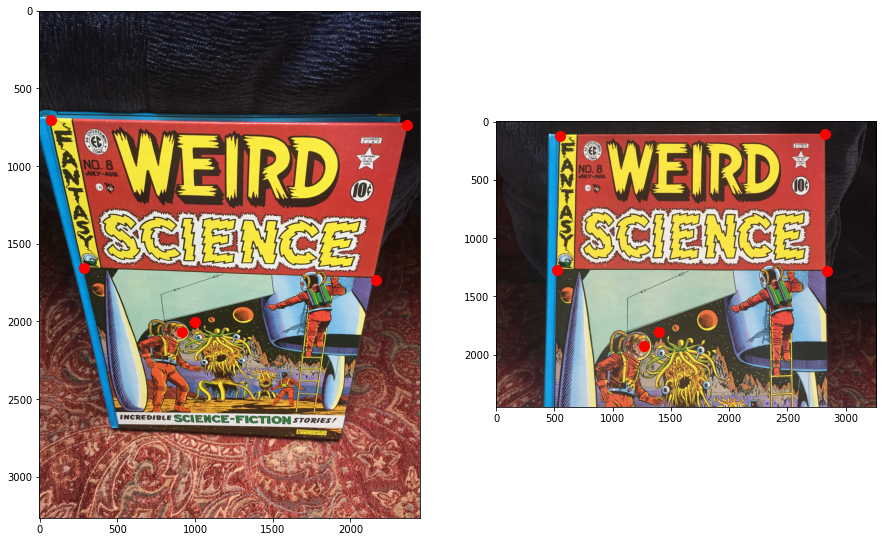

In [ ]:
# Example of loading data
weird1_img = cv2.cvtColor(cv2.imread("/work/data/weird1.jpg"), cv2.COLOR_BGR2RGB)
weird1_points = np.genfromtxt("/work/data/weird1.txt")
weird2_img = cv2.cvtColor(cv2.imread("/work/data/weird2.jpg"), cv2.COLOR_BGR2RGB)
weird2_points = np.genfromtxt("/work/data/weird2.txt")

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(weird1_img)
ax[0].scatter(weird1_points[:,0], weird1_points[:,1], s=100, color='r')
ax[1].imshow(weird2_img)
ax[1].scatter(weird2_points[:,0], weird2_points[:,1], s=100, color='r')

#test stitcher function
stitcher(weird1_img,weird1_points,weird2_img,weird2_points,'weird')

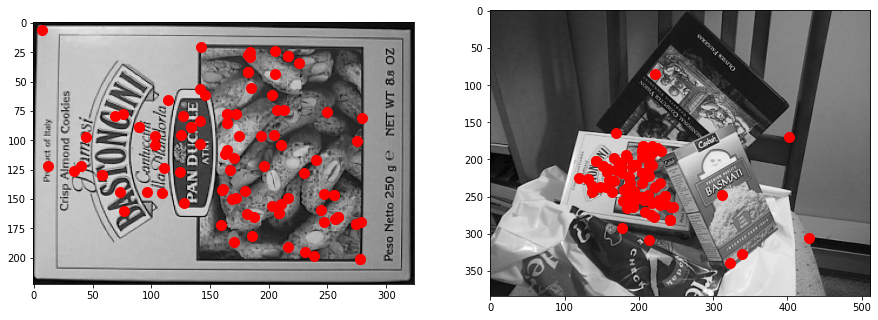

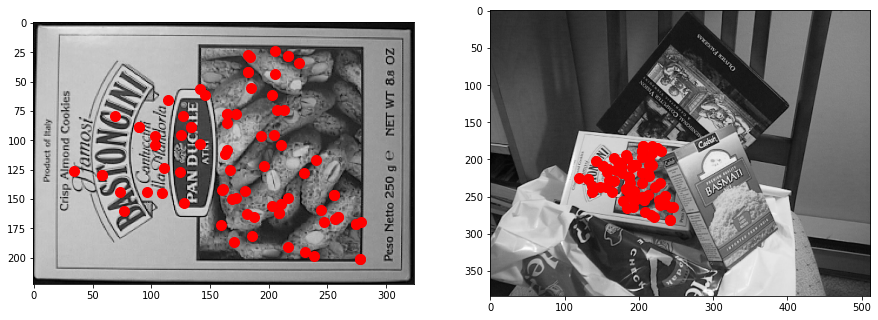

In [ ]:
# Example of loading data
box_img = cv2.cvtColor(cv2.imread("/work/data/box.png"), cv2.COLOR_BGR2RGB)
box_points = np.genfromtxt("/work/data/box.txt")
box_in_scene_img = cv2.cvtColor(cv2.imread("/work/data/box_in_scene.png"), cv2.COLOR_BGR2RGB)
box_in_scene_points = np.genfromtxt("/work/data/box_in_scene.txt")

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(box_img)
ax[0].scatter(box_points[:,0], box_points[:,1], s=100, color='r')
ax[1].imshow(box_in_scene_img)
ax[1].scatter(box_in_scene_points[:,0], box_in_scene_points[:,1], s=100, color='r')

#test ransac function
inliers=ransac_homography(box_points,box_in_scene_points)


new_box_points=[]
new_box_in_scene_points=[]

for inlier in inliers:
    new_box_points.append(box_points[inlier])
    new_box_in_scene_points.append(box_in_scene_points[inlier])

new_box_points=np.asarray(new_box_points)
new_box_in_scene_points=np.asarray(new_box_in_scene_points)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(box_img)
ax[0].scatter(new_box_points[:,0], new_box_points[:,1], s=100, color='r')
ax[1].imshow(box_in_scene_img)
ax[1].scatter(new_box_in_scene_points[:,0], new_box_in_scene_points[:,1], s=100, color='r')

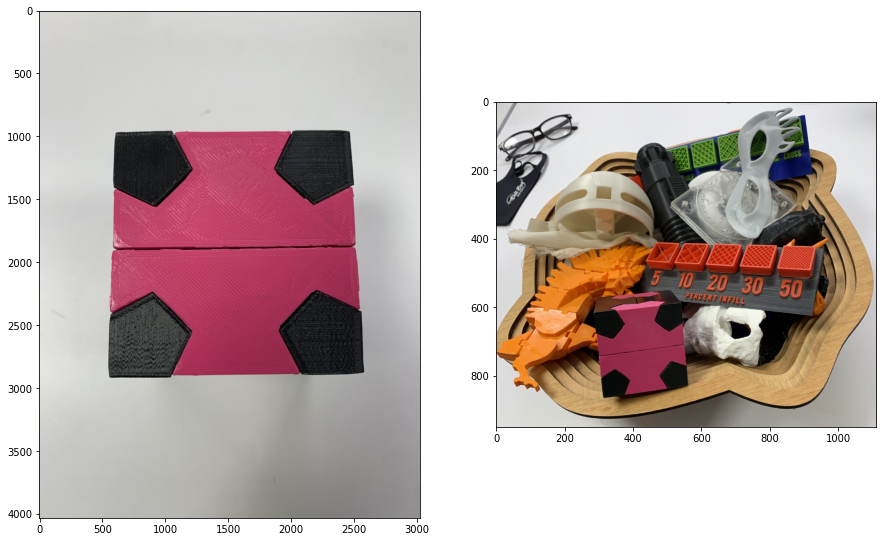

In [ ]:
#loading data
cube_img = cv2.cvtColor(cv2.imread("/work/data/cube.jpg"), cv2.COLOR_BGR2RGB)
cube_basket_img = cv2.cvtColor(cv2.imread("/work/data/cube_basket.png"), cv2.COLOR_BGR2RGB)
cube_points = np.genfromtxt("/work/data/cube.txt")
cube_basket_points = np.genfromtxt("/work/data/cube_basket.txt")

#show data
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cube_img)
ax[1].imshow(cube_basket_img)



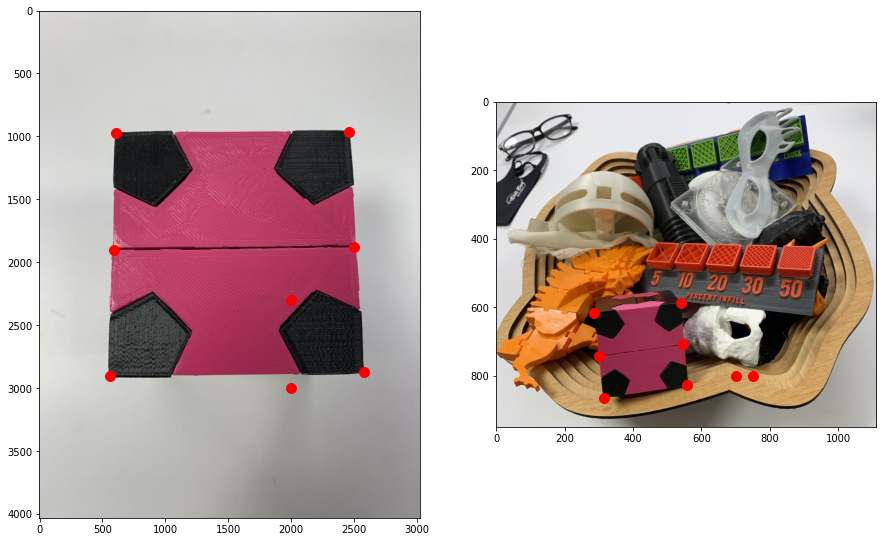

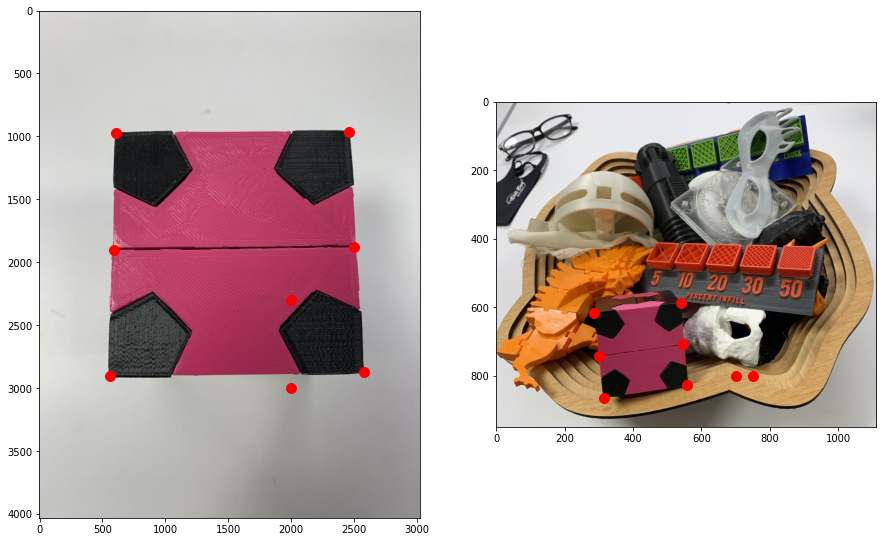

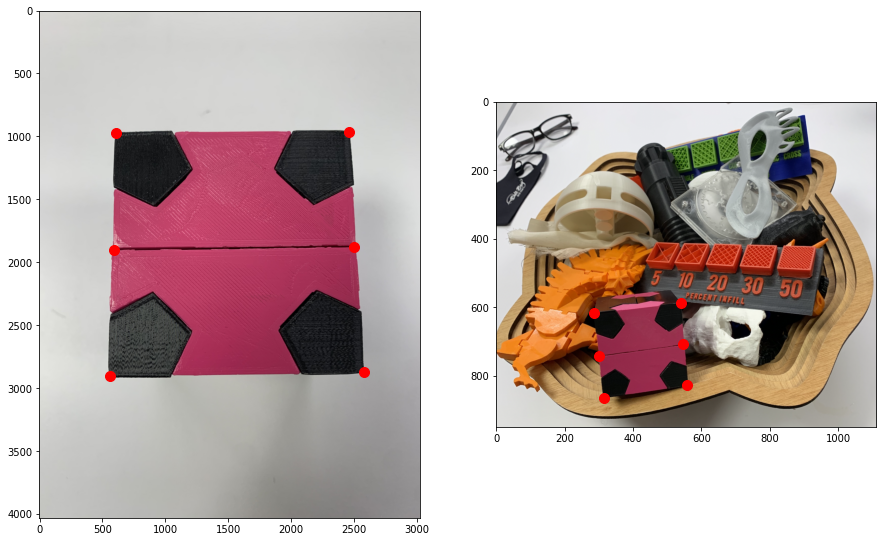

In [ ]:
#show the bad and good correspondences before Ransac
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cube_img)
ax[0].scatter(cube_points[:,0], cube_points[:,1], s=100, color='r')
ax[1].imshow(cube_basket_img)
ax[1].scatter(cube_basket_points[:,0], cube_basket_points[:,1], s=100, color='r')

########################## extra credit attempt##############
# kp2, kp1 = find_correspondeces(cube_basket_img, cube_img)

# fig, ax = plt.subplots(1, 2, figsize=(15,10))
# ax[0].imshow(cube_img)
# ax[0].scatter(kp1[:,0], kp1[:,1], s=100, color='r')
# ax[1].imshow(cube_basket_img)
# ax[1].scatter(kp2[:,0], kp2[:,1], s=100, color='r')

# # run Ransac on the same set of images,then use sticher on the good correspondeces found by Ransac

# # inliers=ransac_homography(cube_points,cube_basket_points)
# inliers=ransac_homography(kp1,kp2)


# new_cube_points=[]
# new_cube_basket_points=[]

# for inlier in inliers:
#     # new_cube_points.append(cube_points[inlier])
#     # new_cube_basket_points.append(cube_basket_points[inlier])
#     new_cube_points.append(kp1[inlier])
#     new_cube_basket_points.append(kp2[inlier])

# new_cube_points=np.asarray(new_cube_points)
# new_cube_basket_points=np.asarray(new_cube_basket_points)

# fig, ax = plt.subplots(1, 2, figsize=(15,10))
# ax[0].imshow(cube_img)
# ax[0].scatter(new_cube_points[:,0], new_cube_points[:,1], s=100, color='r')
# ax[1].imshow(cube_basket_img)
# ax[1].scatter(new_cube_basket_points[:,0], new_cube_basket_points[:,1], s=100, color='r')

# # stitcher(cube_basket_img,cube_basket_points,cube_img,cube_points,'cube')
# stitcher(cube_basket_img,new_cube_basket_points,cube_img,new_cube_points,'cube')
####################



#show the bad and good correspondences before Ransac
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cube_img)
ax[0].scatter(cube_points[:,0], cube_points[:,1], s=100, color='r')
ax[1].imshow(cube_basket_img)
ax[1].scatter(cube_basket_points[:,0], cube_basket_points[:,1], s=100, color='r')

# run Ransac on the same set of images,then use sticher on the good correspondeces found by Ransac
inliers=ransac_homography(cube_points,cube_basket_points)

new_cube_points=[]
new_cube_basket_points=[]

for inlier in inliers:
    new_cube_points.append(cube_points[inlier])
    new_cube_basket_points.append(cube_basket_points[inlier])

new_cube_points=np.asarray(new_cube_points)
new_cube_basket_points=np.asarray(new_cube_basket_points)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cube_img)
ax[0].scatter(new_cube_points[:,0], new_cube_points[:,1], s=100, color='r')
ax[1].imshow(cube_basket_img)
ax[1].scatter(new_cube_basket_points[:,0], new_cube_basket_points[:,1], s=100, color='r')

stitcher(cube_basket_img,new_cube_basket_points,cube_img,new_cube_points,'cube')

### Project Writeup

For the most part, we collaborated on all parts of the project. When tracing the steps and pseudocode for the image stitching and RANSAC algorithm, we wrote the code together in real time, and we went to office hours together to solve the bugs in our program.

When writing the stitcher function, we alternated between editing code and generating data after each “step.” For example, after obtaining the four unmodified corner points of image 1 using cv2.perspectiveTransform, we would print the shape of the points array. This let us know that we needed to reshape the points array, so that we could concatenate it with the four unmodified corner points of image 2 to create the array of eight points. When writing the RANSAC function, we followed a similar approach by printing variables we initialized after each step in the pseudocode. In addition, we changed Nmax from 1000 to 5 during the testing phase so that we would have a better picture of what was going on and to more easily understand what our bugs were.

Most often, the difficulties we encountered were in the functions we called from the cv2 library. Because we were unfamiliar with most of the functions we used for this project, we had to overcome the difficulties with the brute force method by printing every variable these functions initialized and analyzing them internally using .shape or its other fields. For example, we had trouble initializing the four corner points of image 1 with the cv2.perspectiveTransform, but after printing the shape of rect1, we realized that we had to reshape it in order to get the points properly. For the RANSAC function, we encountered difficulties initially translating the pseudocode, but after looking back at our notes and documentation online, we were able to solve them by understanding exactly what RANSAC was doing and all its individual steps.

Below are the images of our program outputs using the stitcher function:

<p align="center"><img src="weird_output.jpg" width="90%" /></p> | <p align="center"><img src="cube_output.jpg" width="60%" /></p>

And below is the image of our program output for the RANSAC algorithm:

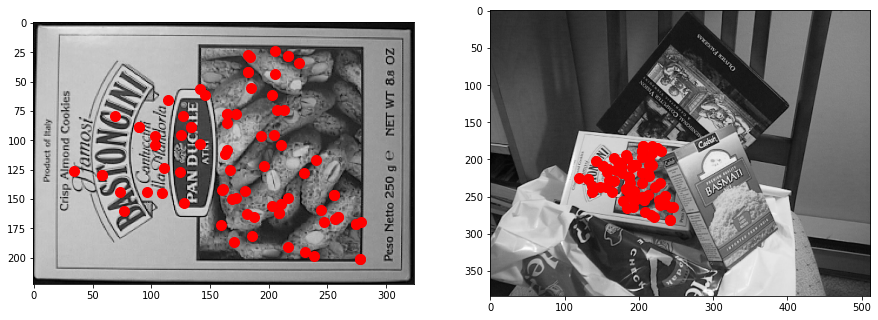

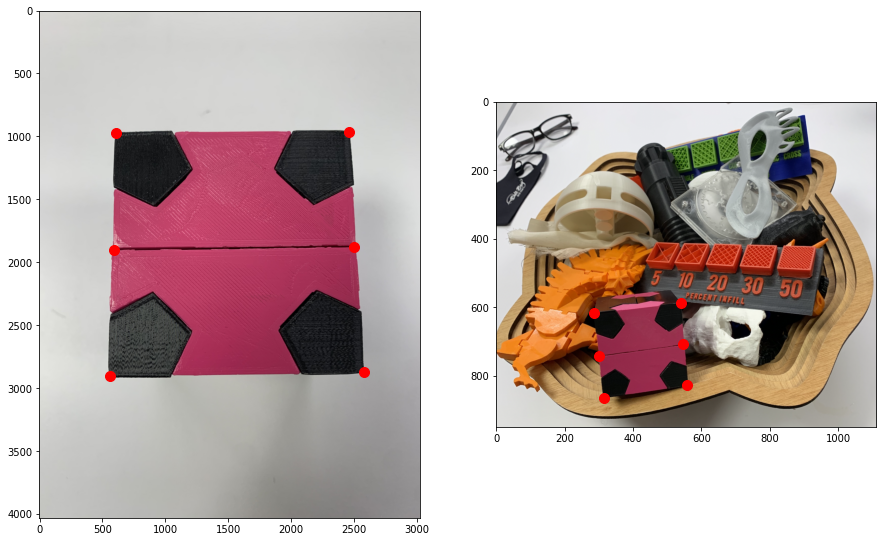

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(box_img)
ax[0].scatter(new_box_points[:,0], new_box_points[:,1], s=100, color='r')
ax[1].imshow(box_in_scene_img)
ax[1].scatter(new_box_in_scene_points[:,0], new_box_in_scene_points[:,1], s=100, color='r')

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cube_img)
ax[0].scatter(new_cube_points[:,0], new_cube_points[:,1], s=100, color='r')
ax[1].imshow(cube_basket_img)
ax[1].scatter(new_cube_basket_points[:,0], new_cube_basket_points[:,1], s=100, color='r')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7b1faa9-3e2e-41ad-b6ed-e45680fcf189' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>